# Customer Centric analysis of Sales Performance

### Objective:
The objective of this notebook is to analyse how the Sales Performance of a seller is related to the experience of their clients. In this case, the Sales Performance is whether a seller has an above average monthly income or not. 

### How:
The hypothesis is that the Sales Performance can be predicted by 4 features:
* The ratio of shipments within Deadline informed to the client
* The average star rating of the seller
* If the seller offers products that belong to top selling categories 
* The population density of the region in which the seller is located


# Data Understanding and preparation

The detailed description of the data under analysis can be accessed in the link below:

https://www.kaggle.com/olistbr/brazilian-ecommerce

In [1]:
#Importing libraries
import pandas as pd
from datetime import datetime
import math
import numpy as np

my_path = '/Users/leonardoyamaguishi/Documents/Udacity/Data-Science/Project 1/data/raw/'

In [2]:
#Reading the data

#Main Orders Dataset
olist_orders_dataset = pd.read_csv(my_path + 'olist_orders_dataset.csv')

#Products that compose each order
olist_order_items_dataset = pd.read_csv(my_path + 'olist_order_items_dataset.csv')

#Details from the Products, including seller_id
olist_products_dataset = pd.read_csv(my_path + 'olist_products_dataset.csv')

#Details from the Sellers, including their geographic state
olist_sellers_dataset = pd.read_csv(my_path + 'olist_sellers_dataset.csv')

#Reviews from orders
olist_order_reviews_dataset = pd.read_csv(my_path + 'olist_order_reviews_dataset.csv')

In [3]:
#IMPORTANT VERIFICATION
#The order_ids are unique and not repeated in the olist_orders_dataset
list1 = olist_orders_dataset['order_id'].sort_values().to_list()
list2 = sorted(list(set(olist_orders_dataset['order_id'])))

list1 == list2
#As this is a table with single order_id values, it can be used as an order lookup table
#The key value would be the order_id with a one to many correspondence

True

In [4]:
#Function for date time handling
def time_converter(df, time_str_column):
    """
    INPUT:
    df - DataFrame that contains a column with time strings, this column must nost contain nan values.
    time_str_column - name of the column with the time strings.
    
    This function converts the time strings in a given column using the strptime function from the datetime library.
    By doing this, a new column with the converted elements will be created and the old column will be dropped.
    
    OUTPUT:
    df - DataFrame with a new converted column with the "con_" prefix.
    
    """
    converted_time = []
    new_column_name = 'conv_' + time_str_column   
    
    for time in df[time_str_column]:
        converted_time.append(datetime.strptime(time, "%Y-%m-%d %H:%M:%S"))
        
    df = df.drop(time_str_column, axis = 1)
    df[new_column_name] = converted_time
    return df

# Sales Performance: Calculating the average monthly income per seller

### Joining the olist_orders_dataset with olist_order_items_dataset on the order_id key
#### Rationale:
The average monthly income calculation is the total revenue (olist_order_items_dataset) divided by the total months since the first registered sale of the seller (olist_orders_dataset).

In [5]:
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [6]:
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
#Left join between olist_order_items_dataset on order_id and olist_orders_dataset
#The objective is to have the order details for every order

orders_and_items_details = olist_order_items_dataset.merge(olist_orders_dataset, on = 'order_id', how = 'left')

#Case in which the key is repeated on olist_order_items_dataset but not on olist_orders_dataset
orders_and_items_details[(orders_and_items_details['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5')]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00


In [8]:
olist_orders_dataset[(olist_orders_dataset['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
36265,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-16 23:04:43,2017-10-27 18:43:56,2017-11-06 00:00:00


In [9]:
#Date string handling on delivered_orders
date_columns = ['order_purchase_timestamp'
                , 'order_approved_at'
                , 'order_delivered_carrier_date'
                , 'order_delivered_customer_date'
                , 'order_estimated_delivery_date']

#Dropping the date columns with non string elements
rows_to_drop = []

for date_column in date_columns:     
    for row, time in enumerate(orders_and_items_details[date_column]):
        if not isinstance(time, str):
            rows_to_drop.append(row)
    
rows_to_drop = list(set(rows_to_drop))
orders_and_items_details = orders_and_items_details.drop(rows_to_drop, axis = 0)

#Converting to datetime format
for date_column in date_columns: 
    orders_and_items_details = time_converter(orders_and_items_details, date_column)

In [10]:
#This analysis is focused on delivered orders
#Filtering the delivered Orders
delivered_orders = orders_and_items_details[(orders_and_items_details['order_status'] == 'delivered')]
delivered_orders[(delivered_orders.isna())].count()

order_id                              0
order_item_id                         0
product_id                            0
seller_id                             0
shipping_limit_date                   0
price                                 0
freight_value                         0
customer_id                           0
order_status                          0
conv_order_purchase_timestamp         0
conv_order_approved_at                0
conv_order_delivered_carrier_date     0
conv_order_delivered_customer_date    0
conv_order_estimated_delivery_date    0
dtype: int64

### Calculating the Revenue per seller

In [11]:
revenue_per_seller = delivered_orders.groupby('seller_id')['price'].sum().to_frame()
revenue_per_seller['total_revenue'] = revenue_per_seller['price']
revenue_per_seller = revenue_per_seller.drop('price', axis = 1)
revenue_per_seller

,total_revenue
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,2685.00
001cca7ae9ae17fb1caed9dfb1094831,24487.03
002100f778ceb8431b7a1020ff7ab48f,1216.60
003554e2dce176b5555353e4f3555ac8,120.00
004c9cd9d87a3c30c522c48c4fc07416,19435.74
...,...
ffc470761de7d0232558ba5e786e57b7,1529.13
ffdd9f82b9a447f6f8d4b91554cc7dd3,2101.20
ffeee66ac5d5a62fe688b9d26f83f534,1839.86


### Calculating the quantity of months since the first sale for each seller

In [12]:
#As the idea is to calculate the Average Monthly Income
#The total income must be divided by the amount of month since the first sale a given seller

#Finding the first register of sale from each seller
first_sell_per_seller = delivered_orders.groupby('seller_id')['conv_order_purchase_timestamp'].min().to_frame()

#Replacing the column name to enhance interpretation
first_sell_per_seller['first_sell_date'] = first_sell_per_seller['conv_order_purchase_timestamp']
first_sell_per_seller = first_sell_per_seller.drop('conv_order_purchase_timestamp', axis = 1) 
first_sell_per_seller

,first_sell_date
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,2017-09-26 22:17:05
001cca7ae9ae17fb1caed9dfb1094831,2017-02-04 19:06:04
002100f778ceb8431b7a1020ff7ab48f,2017-09-14 01:00:31
003554e2dce176b5555353e4f3555ac8,2017-12-15 06:52:25
004c9cd9d87a3c30c522c48c4fc07416,2017-01-27 10:34:34
...,...
ffc470761de7d0232558ba5e786e57b7,2018-02-20 18:47:21
ffdd9f82b9a447f6f8d4b91554cc7dd3,2017-03-05 16:21:27
ffeee66ac5d5a62fe688b9d26f83f534,2017-09-30 15:56:56


In [13]:
#Last date of registered purchase from the entire dataset
max_date = delivered_orders['conv_order_purchase_timestamp'].max()

#The interval in months between the first sale and the register, rounded up
#Used to calculate the average monthly revenue
first_sell_per_seller['total_months'] = first_sell_per_seller['first_sell_date'].apply(lambda x: math.ceil(((max_date - x).days)/30))
first_sell_per_seller

,first_sell_date,total_months
seller_id,,
0015a82c2db000af6aaaf3ae2ecb0532,2017-09-26 22:17:05,12
001cca7ae9ae17fb1caed9dfb1094831,2017-02-04 19:06:04,19
002100f778ceb8431b7a1020ff7ab48f,2017-09-14 01:00:31,12
003554e2dce176b5555353e4f3555ac8,2017-12-15 06:52:25,9
004c9cd9d87a3c30c522c48c4fc07416,2017-01-27 10:34:34,20
...,...,...
ffc470761de7d0232558ba5e786e57b7,2018-02-20 18:47:21,7
ffdd9f82b9a447f6f8d4b91554cc7dd3,2017-03-05 16:21:27,19
ffeee66ac5d5a62fe688b9d26f83f534,2017-09-30 15:56:56,12


### Average monthly revenue per seller

In [14]:
#Average monthly revenue calculation
revenue_per_seller = revenue_per_seller.merge(first_sell_per_seller, on = 'seller_id', how = 'left')
revenue_per_seller['average_monthly_revenue'] = revenue_per_seller['total_revenue']/first_sell_per_seller['total_months']

#revenue_per_seller.to_csv(my_path + 'revenue_data.csv')

In [15]:
revenue_per_seller.describe()

,total_revenue,total_months,average_monthly_revenue
count,2970.000000,2970.000000,2970.000000
mean,4450.639562,10.758923,400.249273
std,13925.591337,6.619765,995.820686
min,6.500000,1.000000,0.361111
25%,219.800000,5.000000,33.991403
50%,844.050000,10.000000,124.751000
75%,3497.880000,17.000000,356.586364
max,226987.930000,24.000000,16764.649231


### Labels to predict: whether the seller average monthly income is above average

In [16]:
#Creating a boolean column to label the sellers with above average monthly revenues
revenue_per_seller['above_average'] = revenue_per_seller['average_monthly_revenue'] >revenue_per_seller['average_monthly_revenue'].mean()

#EDA
revenue_per_seller.to_csv('/Users/leonardoyamaguishi/Documents/Udacity/Data-Science/Project 1/data/' + 'revenue_per_seller.csv')

#Creating the y dataframe
seller_performance = revenue_per_seller['above_average']
seller_performance

seller_id
0015a82c2db000af6aaaf3ae2ecb0532    False
001cca7ae9ae17fb1caed9dfb1094831     True
002100f778ceb8431b7a1020ff7ab48f    False
003554e2dce176b5555353e4f3555ac8    False
004c9cd9d87a3c30c522c48c4fc07416     True
                                    ...  
ffc470761de7d0232558ba5e786e57b7    False
ffdd9f82b9a447f6f8d4b91554cc7dd3    False
ffeee66ac5d5a62fe688b9d26f83f534    False
fffd5413c0700ac820c7069d66d98c89     True
ffff564a4f9085cd26170f4732393726    False
Name: above_average, Length: 2970, dtype: bool

# Variables for prediction

## Ratio of shipments within informed estimated delivery date
### Definition:
This feature describes quantitatively if the seller, historically meets the estimated delivery date informed to the client.

In [17]:
shipping_dataset = delivered_orders

#Calculate the interval in days between the day of delivery and the estimated delivery date
expected_date_met = []

for delivery, expectation in zip(shipping_dataset['conv_order_delivered_customer_date']
                                 , shipping_dataset['conv_order_estimated_delivery_date']):
    if delivery < expectation:
        expected_date_met.append(1)
    else:
        expected_date_met.append(0)
shipping_dataset['within_expected_delivery_date'] = expected_date_met
shipping_dataset.head()

<ipython-input-17-1b8c56e65ab1>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shipping_dataset['within_expected_delivery_date'] = expected_date_met


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,conv_order_purchase_timestamp,conv_order_approved_at,conv_order_delivered_carrier_date,conv_order_delivered_customer_date,conv_order_estimated_delivery_date,within_expected_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,1
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,1


In [18]:
#Validating if all items from a given order are delivered at once
verification1 = shipping_dataset.groupby('order_id')['conv_order_estimated_delivery_date'].max()
verification2 = shipping_dataset.groupby('order_id')['conv_order_estimated_delivery_date'].min()

(verification1 == verification2).count()/len(verification1)

1.0

In [19]:
#Calculating the ratio
within_deadline_data = shipping_dataset.groupby('seller_id')['within_expected_delivery_date'].mean().to_frame()
#Although the mean is computed, it will be equivalent to the percentage of deliveries within the deadline

within_deadline_data

,within_expected_delivery_date
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,1.000000
001cca7ae9ae17fb1caed9dfb1094831,0.944444
002100f778ceb8431b7a1020ff7ab48f,0.833333
003554e2dce176b5555353e4f3555ac8,1.000000
004c9cd9d87a3c30c522c48c4fc07416,0.922156
...,...
ffc470761de7d0232558ba5e786e57b7,0.933333
ffdd9f82b9a447f6f8d4b91554cc7dd3,1.000000
ffeee66ac5d5a62fe688b9d26f83f534,0.857143


## Average star rating per seller
### Definition:
Gives an overall description of the service and product.

In [20]:
star_ratings = olist_order_reviews_dataset[['review_id', 'order_id', 'review_score']]
star_ratings.head()

,review_id,order_id,review_score
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5


In [21]:
#Calculating the average star rating per seller
star_ratings = star_ratings.groupby('order_id')['review_score'].mean().to_frame()

#To retrieve the seller id, it is necessary to join the olist_orders_dataset and the olist_order_items_dataset
star_order_data = star_ratings.merge(olist_orders_dataset, on = 'order_id')

#Filtering the data, as the objective is to analyse only delivered orders
star_order_data = star_order_data[(star_order_data['order_status'] == 'delivered')]

In [22]:
#Joining the order items dataset to retrieve the seller id per order id
#This will result in repeated registers per order_id
star_seller_data = star_order_data.merge(olist_order_items_dataset, on = 'order_id', how = 'left')

In [23]:
#There is at least one review per delivered order
star_seller_data['review_score'].sort_values(axis = 0, ascending = False) 

average_seller_ratings = star_seller_data.groupby('seller_id')['review_score'].mean().to_frame()

In [24]:
average_seller_ratings

,review_score
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,3.666667
001cca7ae9ae17fb1caed9dfb1094831,3.935897
002100f778ceb8431b7a1020ff7ab48f,4.037037
003554e2dce176b5555353e4f3555ac8,5.000000
004c9cd9d87a3c30c522c48c4fc07416,4.127976
...,...
ffc470761de7d0232558ba5e786e57b7,4.300000
ffdd9f82b9a447f6f8d4b91554cc7dd3,4.250000
ffeee66ac5d5a62fe688b9d26f83f534,4.214286


## If the seller offers products that belong to top selling categories
### Hypothesis:
Sellers that offer products that belong to top selling categories may be more evident for customers.

### Defining the trending categories
The trending categories will be the top 10 categories with the highest monthly revenues.
The monthly revenues will be calculated by dividing the total revenue by the months since the first sale of the category.

In [25]:
#Creating a dataframe that lists, from the delivered orders, the category of the sold products and their sellers
delivered_orders_product_details = delivered_orders.merge(olist_products_dataset, on = 'product_id', how = 'left')
delivered_orders_product_details = delivered_orders_product_details[(delivered_orders_product_details['order_status'] == 'delivered')]

In [26]:
#Defining the trending categories
category_list = list(set(delivered_orders_product_details['product_category_name']))
category_revenue = []

#listing the revenue per category
for category in category_list:
    filtered_df = delivered_orders_product_details[(delivered_orders_product_details['product_category_name'] == category)]
    category_revenue.append(filtered_df['price'].sum())
    
category_revenue_df = pd.DataFrame({'product_category_name' : category_list, 'revenue': category_revenue})
category_revenue_df.sort_values(by = ['revenue'], ascending = False)

,product_category_name,revenue
46,beleza_saude,1233131.72
72,relogios_presentes,1165898.98
25,cama_mesa_banho,1023300.77
47,esporte_lazer,954604.57
61,informatica_acessorios,888613.62
...,...,...
7,casa_conforto_2,760.27
12,cds_dvds_musicais,730.00
56,fashion_roupa_infanto_juvenil,519.95
10,seguros_e_servicos,283.29


In [27]:
#First sale per category
first_sale_per_category = delivered_orders_product_details.groupby(['product_category_name'])['conv_order_purchase_timestamp'].min().to_frame()
first_sale_per_category['first_sale'] = first_sale_per_category['conv_order_purchase_timestamp'] 
first_sale_per_category = first_sale_per_category.drop('conv_order_purchase_timestamp', axis = 1)

#The interval in months between the first sale and the register, rounded up
#Used to calculate the average monthly revenue
first_sale_per_category['total_months'] = first_sale_per_category['first_sale'].apply(lambda x: math.ceil(((max_date - x).days)/30))
first_sale_per_category

,first_sale,total_months
product_category_name,,
agro_industria_e_comercio,2017-01-23 07:03:04,20
alimentos,2016-10-10 11:22:36,23
alimentos_bebidas,2017-03-09 10:24:00,18
artes,2017-03-01 10:56:53,19
artes_e_artesanato,2017-05-08 12:01:54,16
...,...,...
sinalizacao_e_seguranca,2017-03-27 19:30:45,18
tablets_impressao_imagem,2017-02-02 17:22:31,20
telefonia,2016-10-04 19:30:28,24


In [28]:
category_monthly_revenue_df = category_revenue_df.merge(first_sale_per_category, on = 'product_category_name', how = 'left')
category_monthly_revenue_df['average_monthly_revenue'] = category_monthly_revenue_df['revenue']/category_monthly_revenue_df['total_months']
category_monthly_revenue_df = category_monthly_revenue_df.sort_values(by = 'average_monthly_revenue', ascending = False)
category_monthly_revenue_df['average_monthly_revenue'].describe()

count       73.000000
mean      7738.192693
std      12151.476460
min         14.164500
25%        435.513750
50%       2262.812500
75%       9122.211000
max      51380.488333
Name: average_monthly_revenue, dtype: float64

In [29]:
top_trending_categories = list(category_monthly_revenue_df['product_category_name'][:10:])
top_trending_categories

['beleza_saude',
 'relogios_presentes',
 'cama_mesa_banho',
 'esporte_lazer',
 'informatica_acessorios',
 'moveis_decoracao',
 'utilidades_domesticas',
 'cool_stuff',
 'automotivo',
 'brinquedos']

### Listing the categories offered by each seller

In [30]:
product_seller_category = delivered_orders_product_details[['product_id', 'seller_id', 'product_category_name']]
product_seller_category

,product_id,seller_id,product_category_name
0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff
1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop
2,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao
3,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria
4,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim
...,...,...,...
110168,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,utilidades_domesticas
110169,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,informatica_acessorios
110170,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,esporte_lazer
110171,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,informatica_acessorios


In [31]:
seller_list = list(set(product_seller_category['seller_id']))
seller_categories = {}

#listing the categories offered by each seller
for seller in seller_list:
    filtered_df = product_seller_category[(product_seller_category['seller_id'] == seller)]
    seller_categories[seller] = list(set(filtered_df['product_category_name']))

### Checking which of the sellers offer products from trending categories

In [32]:
has_category_list = []
has_category = 0

for seller in seller_list:
    for trending_category in top_trending_categories:
        if trending_category in seller_categories[seller]:
            has_category = 1
    has_category_list.append(has_category)
    has_category = 0

has_trending_df = pd.DataFrame({'seller_id' : seller_list, 'offer_trending_category' : has_category_list})
has_trending_df        

,seller_id,offer_trending_category
0,751bdc4d83a466c7206cd42e8f426b03,1
1,20cb7c2fde3e5bf10f0bbe7394e1c6a9,1
2,d4f117125b59ce73c3302f88ee40c458,1
3,41c2bad7229b0c25e6becf179ebf63ff,0
4,11d4c477d09821164bca4f70a2eae031,0
...,...,...
2965,c447f8dd3ed213f291d65ef074a268eb,1
2966,3606774ec64634822d78dc2db6d37045,0
2967,3fefda3299e6dfaea3466ef346a3571a,0
2968,6bb66d9870c2e01c05655c7ed0e7ee13,0


## The population density of the region in which the seller is located
### Hypothesis:
Sellers located in states with higher population densities may have a logistical advantage, if this information is mentioned on the website, it could have a positive impact for most of the customers, specially if the majority of the customers are located in states with higher population density.

Population density per state (hab/kmˆ2) in 2021. Source: https://www.ibge.gov.br/cidades-e-estados/am.html

In [33]:
states = sorted(list(set(has_trending_df.merge(olist_sellers_dataset, on = 'seller_id', how = 'left')['seller_state'])))
dem_density = [2.23, 24.82, 56.76, 444.07, 76.25, 17.65, 19.81, 33.41
 , 6.86, 3.36, 6.07, 66.70, 89.63, 12.40, 52.40, 365.23
 , 59.99, 6.58, 39.79, 65.29, 94.35, 166.25]

dem_density_per_state = pd.DataFrame({'seller_state': states, 'state_population_density': dem_density})
dem_density_per_state

,seller_state,state_population_density
0,AM,2.23
1,BA,24.82
2,CE,56.76
3,DF,444.07
4,ES,76.25
5,GO,17.65
6,MA,19.81
7,MG,33.41
8,MS,6.86
9,MT,3.36


In [34]:
seller_state_demography = olist_sellers_dataset.merge(dem_density_per_state, on = 'seller_state', how = 'left')
seller_demographical_data = has_trending_df.merge(seller_state_demography, on = 'seller_id', how = 'left')
seller_demographical_data = seller_demographical_data[['seller_id', 'state_population_density']]
seller_demographical_data

,seller_id,state_population_density
0,751bdc4d83a466c7206cd42e8f426b03,166.25
1,20cb7c2fde3e5bf10f0bbe7394e1c6a9,52.40
2,d4f117125b59ce73c3302f88ee40c458,166.25
3,41c2bad7229b0c25e6becf179ebf63ff,59.99
4,11d4c477d09821164bca4f70a2eae031,166.25
...,...,...
2965,c447f8dd3ed213f291d65ef074a268eb,166.25
2966,3606774ec64634822d78dc2db6d37045,166.25
2967,3fefda3299e6dfaea3466ef346a3571a,52.40
2968,6bb66d9870c2e01c05655c7ed0e7ee13,166.25


# Final Dataset:

In [35]:
features_df = within_deadline_data.merge(average_seller_ratings, on = 'seller_id', how = 'left')
features_df = features_df.merge(has_trending_df, on = 'seller_id', how = 'left')
features_df = features_df.merge(seller_demographical_data, on = 'seller_id', how = 'left')
features_df = features_df.merge(seller_performance, on = 'seller_id', how = 'left')


features_df.to_csv('/Users/leonardoyamaguishi/Documents/Udacity/Data-Science/Project 1/data/' + 'modelling_df.csv')
features_df

,seller_id,within_expected_delivery_date,review_score,offer_trending_category,state_population_density,above_average
0,0015a82c2db000af6aaaf3ae2ecb0532,1.000000,3.666667,0,166.25,False
1,001cca7ae9ae17fb1caed9dfb1094831,0.944444,3.935897,0,76.25,True
2,002100f778ceb8431b7a1020ff7ab48f,0.833333,4.037037,1,166.25,False
3,003554e2dce176b5555353e4f3555ac8,1.000000,5.000000,0,17.65,False
4,004c9cd9d87a3c30c522c48c4fc07416,0.922156,4.127976,1,166.25,True
...,...,...,...,...,...,...
2965,ffc470761de7d0232558ba5e786e57b7,0.933333,4.300000,1,166.25,False
2966,ffdd9f82b9a447f6f8d4b91554cc7dd3,1.000000,4.250000,1,52.40,False
2967,ffeee66ac5d5a62fe688b9d26f83f534,0.857143,4.214286,0,166.25,False
2968,fffd5413c0700ac820c7069d66d98c89,0.862069,3.931034,1,166.25,True


array([[<AxesSubplot:title={'center':'within_expected_delivery_date'}>,
        <AxesSubplot:title={'center':'review_score'}>],
       [<AxesSubplot:title={'center':'offer_trending_category'}>,
        <AxesSubplot:title={'center':'state_population_density'}>]],
      dtype=object)

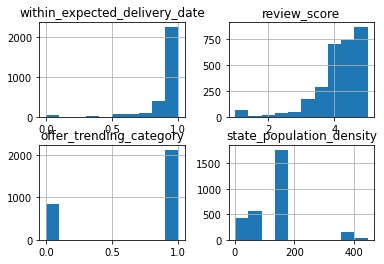

In [36]:
features_df.hist()

In [37]:
#Analysing the correlations applying the Spearman method, as the data is not normally distributed
#Assuming a monotinic relationship between the variables
features_df.corr(method = 'spearman')

,within_expected_delivery_date,review_score,offer_trending_category,state_population_density,above_average
within_expected_delivery_date,1.000000,0.392793,-0.120904,-0.146560,-0.239203
review_score,0.392793,1.000000,-0.063090,-0.054766,-0.095456
offer_trending_category,-0.120904,-0.063090,1.000000,0.005977,0.139132
state_population_density,-0.146560,-0.054766,0.005977,1.000000,0.018045
above_average,-0.239203,-0.095456,0.139132,0.018045,1.000000
